# Chapter 10 semilinear SPDEs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import scipy
from scipy import sparse
from scipy.sparse import linalg
from mpl_toolkits.mplot3d import Axes3D
import Utils
import time

In [ ]:
def icspde_dst1(u):
    return scipy.fftpack.dst(u,type=1,axis=0)/2
def get_onedD_bj(dtref,J,a,r):
    jj=np.arange(1,J)
    myeps=0.001
    return np.sqrt(2 * dtref * jj ** - (2 * r + 1 + myeps) / a)
#
def get_onedD_dW(bj,kappa,iFspace,M,s0):
    if (kappa == 1):
        nn=s0.randn(M,bj.size)
    else:
        nn=np.sum(s0.randn(kappa,M,bj.size),axis=0)
    X=(bj*nn)
    if (iFspace == 1):
        dW=X
    else:
        dW=icspde_dst1(np.squeeze(X))
        dW=dW.reshape(X.shape)
    return dW

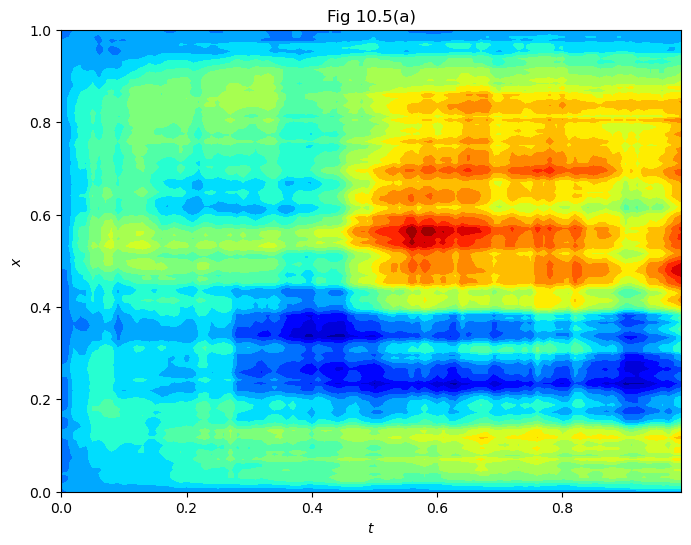

In [19]:
dtref=0.01; kappa=100; r=1/2; J=128; a=1
bj=get_onedD_bj(dtref,J,a,r)
s0=np.random.RandomState()
dW=get_onedD_dW(bj,kappa,0,1,s0)
WW=np.zeros((J+1,100)); t=np.zeros(100)
for k in range(99):
  dW=get_onedD_dW(bj,kappa,0,1,s0)
  WW[1:-1,k+1]=WW[1:-1,k]+dW
  t[k+1]=(k+1)*dtref
x=np.linspace(0,a,J-1)
#
fig, ax = plt.subplots(figsize=(8, 6))
[T,X]=np.meshgrid(t,np.linspace(0,a,J+1))
CS=ax.contourf(T,X,WW, levels=20, cmap='jet')
s=ax.set_xlabel(r'$t$')
s=ax.set_ylabel(r'$x$')
s=ax.set_title(r'Fig 10.5(a)') # change r to 2 for Fig 10.5(b)